In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import graphviz 
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

**Loading Data**

In [2]:
loan_df = pd.read_csv('Loan_data.csv')

In [3]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Observations:**
* We can see there are total 13 columns including target variable, all of them are self explanatory.
* We also see some missing values, lets take stock of missing columns and what are the possible values for categorical and numerical columns

In [4]:
loan_df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [5]:
# Count number of Categorical and Numerical Columns
loan_df = loan_df.drop(columns='Loan_ID')
categorical_col = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed','Credit_History', 'Loan_Amount_Term','Property_Area']
numerical_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
print(categorical_col)
print(numerical_col)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term', 'Property_Area']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


**Analyze values assigned to columns**

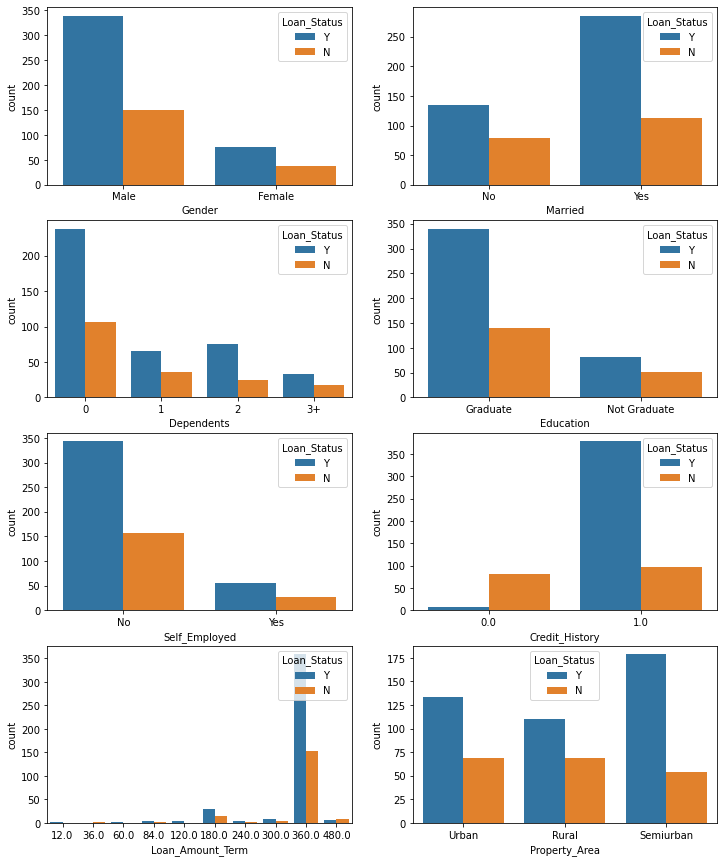

In [6]:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for i,cat_col in enumerate(categorical_col):
    row,col = i//2,i%2
    sns.countplot(x=cat_col,data=loan_df,hue='Loan_Status',ax=axes[row,col])

**Plots above convey following things about the dataset:**
* Loan Approval Status: About 2/3rd of applicants have been granted loan.
* Sex: There are more Men than Women (approx. 3x)
* Martial Status: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
* Dependents: Majority of the population have zero dependents and are also likely to accepted for loan.
* Education: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
* Employment: 5/6th of population is not self employed.
* Property Area: More applicants from Semi-urban and also likely to be granted loans.
* Applicant with credit history are far more likely to be accepted.
* Loan Amount Term: Majority of the loans taken are for 360 Months (30 years).

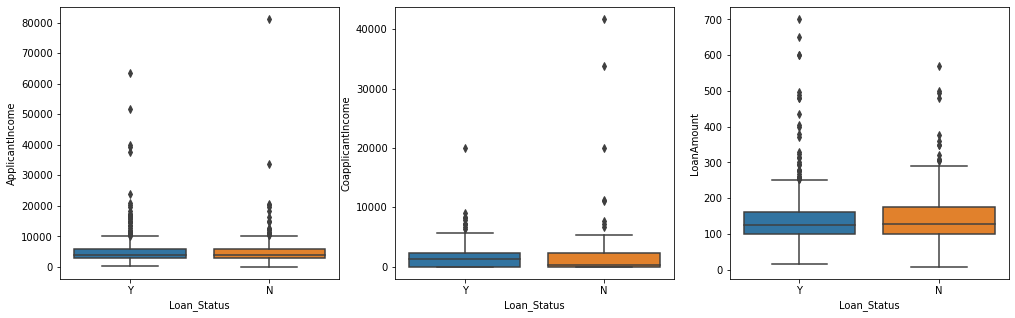

In [7]:
fig,axes = plt.subplots(1,3,figsize=(17,5))
for i,num_col in enumerate(numerical_col):
    sns.boxplot(y=num_col,data=loan_df,x='Loan_Status',ax=axes[i])

* There is no significant relation to Loan approval status

**Preprocessing Data:**

Input data needs to be pre-processed before we feed it to model. Following things need to be taken care:
* Encoding Categorical Features.
* Imputing missing values

In [8]:
# Encoding categrical Features
loan_df_E = pd.get_dummies(loan_df,drop_first=True)
loan_df_E.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,NaN,360.0,1.0,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1,1


In [9]:
loan_df.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [10]:
loan_df_E.isna().sum()

ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                 22
Loan_Amount_Term           14
Credit_History             50
Gender_Male                 0
Married_Yes                 0
Dependents_1                0
Dependents_2                0
Dependents_3+               0
Education_Not Graduate      0
Self_Employed_Yes           0
Property_Area_Semiurban     0
Property_Area_Urban         0
Loan_Status_Y               0
dtype: int64

In [11]:
# Split Features and Target Varible
X = loan_df_E.drop(columns='Loan_Status_Y')
y = loan_df_E['Loan_Status_Y']

# Splitting into Train -Test Data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify =y,random_state =42)

# Handling/Imputing Missing values
imp = SimpleImputer(strategy='mean')
imp_train = imp.fit(X_train)
X_train = imp_train.transform(X_train)
X_test_imp = imp_train.transform(X_test)

**Model 1: Decision Tree Classifier**

In [12]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_train)
print("Training Data set Accuracy:", accuracy_score(y_train,y_pred))
print("Training Data F1 score:",f1_score(y_train,y_pred))
print("Validation Mean F1 score:",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy:",cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Training Data set Accuracy: 1.0
Training Data F1 score: 1.0
Validation Mean F1 score: 0.6570016605654858
Validation Mean Accuracy: 0.7046794475365903


**Overfitting Problem**
* We can see from above metrics that Training Accuracy > Test Accuracy with default settings of Decision Tree classifier. Hence, model is overfit. We will try some Hyper-parameter tuning and see if it helps.

**First let's try tuning 'Max_Depth' of tree**

In [13]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
tree_depths =[]

for depth in range(1,20):
    tree_clf = DecisionTreeClassifier(max_depth=depth)
    tree_clf.fit(X_train,y_train)
    y_train_pred = tree_clf.predict(X_train)
    
    training_acc = accuracy_score(y_train,y_train_pred)
    train_f1 = f1_score(y_train,y_train_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    tree_depths.append(depth)
    
Tuning_Max_depth = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Max_Depth": tree_depths }
Tuning_Max_depth_df = pd.DataFrame.from_dict(Tuning_Max_depth)


<AxesSubplot:xlabel='Max_Depth', ylabel='Values'>

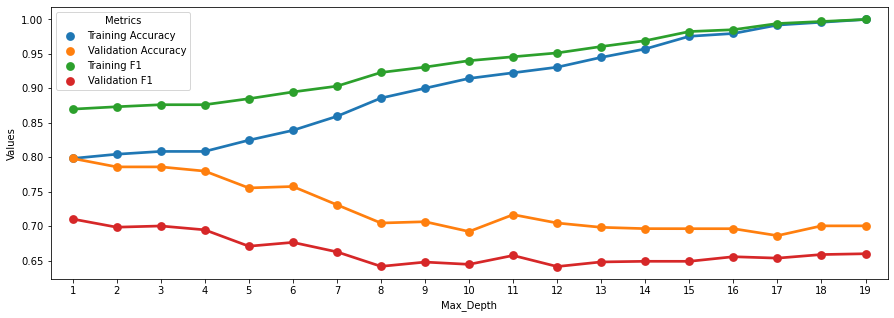

In [14]:
plot_df = Tuning_Max_depth_df.melt('Max_Depth',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Max_Depth", y="Values",hue="Metrics", data=plot_df,ax=ax)

* From above graph, we can conclude that keeping 'Max_Depth' = 3 will yield optimum Test accuracy and F1 score Optimum Test Accuracy ~ 0.805; Optimum F1 Score: ~0.7

**Visulazing Decision Tree with Max Depth = 3**

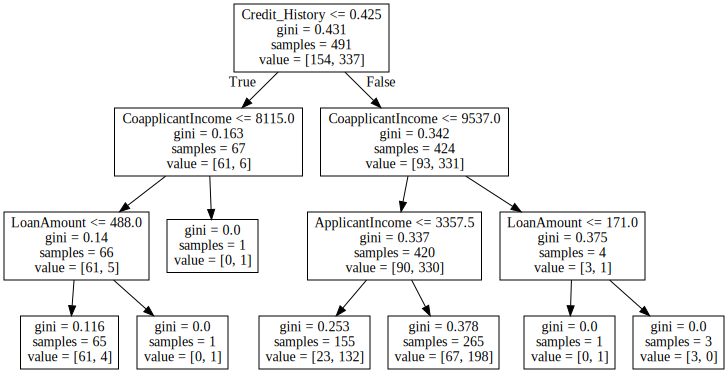

In [15]:
tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train,y_train)
dot_data =tree.export_graphviz(tree_clf,feature_names = X.columns.tolist())
graph = graphviz.Source(dot_data)
graph

* From above tree, we could see that some of the leafs have less than 5 samples hence our classifier might overfit. We can sweep hyper-parameter 'min_samples_leaf' to further improve test accuracy by keeping max_depth to 3

<AxesSubplot:xlabel='Min_Samples_leaf', ylabel='Values'>

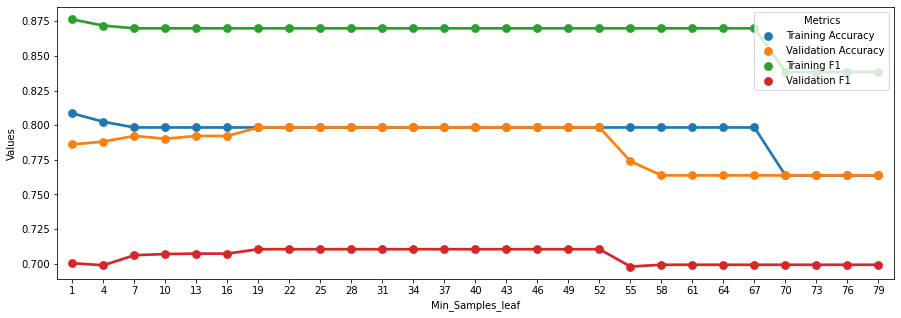

In [16]:
training_accuracy = []
val_accuracy = []
training_f1 = []
val_f1 = []
min_samples_leaf = []

for samples_leaf in range(1,80,3):# Sweeping from 1% samples to 10% samples per leaf 
    tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = samples_leaf)
    tree_clf.fit(X_train,y_train)
    y_training_pred = tree_clf.predict(X_train)
    
    training_acc = accuracy_score(y_train,y_training_pred)
    train_f1 = f1_score(y_train,y_training_pred)
    val_mean_f1 = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='f1_macro').mean()
    val_mean_accuracy = cross_val_score(tree_clf,X_train,y_train,cv=5,scoring='accuracy').mean()
    
    training_accuracy.append(training_acc)
    val_accuracy.append(val_mean_accuracy)
    training_f1.append(train_f1)
    val_f1.append(val_mean_f1)
    min_samples_leaf.append(samples_leaf)
    
Tuning_min_samples_leaf = {"Training Accuracy": training_accuracy, "Validation Accuracy": val_accuracy, "Training F1": training_f1, "Validation F1":val_f1, "Min_Samples_leaf": min_samples_leaf }
Tuning_min_samples_leaf_df = pd.DataFrame.from_dict(Tuning_min_samples_leaf)

plot_df = Tuning_min_samples_leaf_df.melt('Min_Samples_leaf',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Min_Samples_leaf", y="Values",hue="Metrics", data=plot_df,ax=ax)

* From above plot, we will choose Min_Samples_leaf to 35 to improve test accuracy.

* Let's use this Decision Tree classifier on unseen test data and evaluate **Test Accuracy, F1 Score and Confusion Matrix**

In [17]:
tree_clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf = 35)
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8536585365853658
Test F1 Score:  0.903225806451613
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,21,17,38
1,1,84,85
All,22,101,123


**Mis-classifications**

It can be seen that majority of the misclassifications are happening because of Loan Reject applicants being classified as Accept.

**Model 2: Random Forest Classifier**

In [18]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=3,min_samples_leaf = 10)
rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_train)
print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(rf_clf,X_train,y_train,cv=5,scoring='accuracy').mean())

Train F1 Score  0.8713910761154856
Train Accuracy  0.8004073319755601
Validation Mean F1 Score:  0.7021300922943281
Validation Mean Accuracy:  0.7943310657596372


**Random Forest: Test Data Evaluation**

In [19]:
y_pred = rf_clf.predict(X_test_imp)
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8536585365853658
Test F1 Score:  0.903225806451613
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,21,17,38
1,1,84,85
All,22,101,123


* Random Forest gives same results as Decision Tree Classifier. Finally, we will try Logistic Regression Model by sweeping threshold values.

**Model 3: Logistic Regression**

<AxesSubplot:xlabel='Decision Threshold', ylabel='Values'>

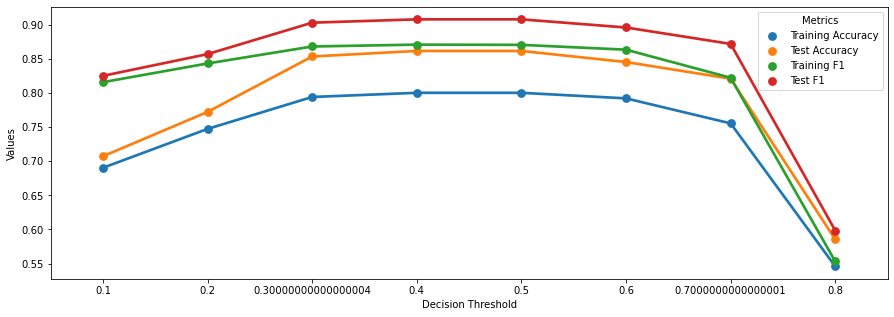

In [20]:
train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []
thresholds = []

#for thresh in np.linspace(0.1,0.9,8): ## Sweeping from threshold of 0.1 to 0.9
for thresh in np.arange(0.1,0.9,0.1): ## Sweeping from threshold of 0.1 to 0.9
    logreg_clf = LogisticRegression(solver='liblinear')
    logreg_clf.fit(X_train,y_train)
    
    y_pred_train_thresh = logreg_clf.predict_proba(X_train)[:,1]
    y_pred_train = (y_pred_train_thresh > thresh).astype(int)

    train_acc = accuracy_score(y_train,y_pred_train)
    train_f1 = f1_score(y_train,y_pred_train)
    
    y_pred_test_thresh = logreg_clf.predict_proba(X_test_imp)[:,1]
    y_pred_test = (y_pred_test_thresh > thresh).astype(int) 
    
    test_acc = accuracy_score(y_test,y_pred_test)
    test_f1 = f1_score(y_test,y_pred_test)
    
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
    test_accuracies.append(test_acc)
    test_f1_scores.append(test_f1)
    thresholds.append(thresh)
    
    
Threshold_logreg = {"Training Accuracy": train_accuracies, "Test Accuracy": test_accuracies, "Training F1": train_f1_scores, "Test F1":test_f1_scores, "Decision Threshold": thresholds }
Threshold_logreg_df = pd.DataFrame.from_dict(Threshold_logreg)

plot_df = Threshold_logreg_df.melt('Decision Threshold',var_name='Metrics',value_name="Values")
fig,ax = plt.subplots(figsize=(15,5))
sns.pointplot(x="Decision Threshold", y="Values",hue="Metrics", data=plot_df,ax=ax)

* Logistic Regression does slightly better than Decision Tree and Random Forest.
* Based on the above Test/Train curves, we can keep threshold to 0.4.
* Now Finally let's look at Logistic Regression Confusion Matrix

In [21]:
thresh = 0.4 ### Threshold chosen from above Curves
y_pred_test_thresh = logreg_clf.predict_proba(X_test_imp)[:,1]
y_pred = (y_pred_test_thresh > thresh).astype(int) 
print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Test Accuracy:  0.8617886178861789
Test F1 Score:  0.9081081081081082
Confusion Matrix on Test Data


Predicted,0,1,All
True,,,
0,22,16,38
1,1,84,85
All,23,100,123


* Logistic Regression Confusion matrix is very similar to Decision Tree and Random Forest Classifier. In this analysis, we did extensive analysis of input data and were able to achieve Test Accuracy of **86%**